In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.nn import Module, Sequential
from torch.nn import Linear, ReLU, Sigmoid, LeakyReLU
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
torch.cuda.set_device(0)

In [4]:
file_path="../20240312_Deep_Learning/NN_Classification/housepricedata.csv"

In [5]:
df = pd.read_csv(file_path)

In [6]:
df.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,AboveMedianPrice
0,8450,7,5,856,2,1,3,8,0,548,1
1,9600,6,8,1262,2,0,3,6,1,460,1
2,11250,7,5,920,2,1,3,6,1,608,1
3,9550,7,5,756,1,0,3,7,1,642,0
4,14260,8,5,1145,2,1,4,9,1,836,1


In [7]:
df.shape

(1460, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   LotArea           1460 non-null   int64
 1   OverallQual       1460 non-null   int64
 2   OverallCond       1460 non-null   int64
 3   TotalBsmtSF       1460 non-null   int64
 4   FullBath          1460 non-null   int64
 5   HalfBath          1460 non-null   int64
 6   BedroomAbvGr      1460 non-null   int64
 7   TotRmsAbvGrd      1460 non-null   int64
 8   Fireplaces        1460 non-null   int64
 9   GarageArea        1460 non-null   int64
 10  AboveMedianPrice  1460 non-null   int64
dtypes: int64(11)
memory usage: 125.6 KB


In [9]:
X = df.drop("AboveMedianPrice", axis=1)
y = df["AboveMedianPrice"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

In [12]:
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

In [13]:
#Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [14]:
class Neural_Network(Module):
    def __init__(self, num_features: int, num_classes: int):
        super(Neural_Network, self).__init__()

        # Hyperparameters
        self.layer_1_neurons = 30
        self.layer_2_neurons = 20
        self.layer_3_neurons = 10
        self.regularization_factor = 0.001
        self.learning_rate = 0.002
        self.num_epochs = 500

        # Layers
        self.fc_input = Sequential(
            Linear(num_features, self.layer_1_neurons),
            LeakyReLU()
        )

        self.fc_l1 = Sequential(
            Linear(self.layer_1_neurons, self.layer_2_neurons),
            LeakyReLU()
        )

        self.fc_l2 = Sequential(
            Linear(self.layer_2_neurons, self.layer_3_neurons),
            LeakyReLU()
        )

        self.fc_output = Sequential(
            Linear(self.layer_3_neurons, num_classes),
            Sigmoid()
        )

        self.optimizer = Adam(self.parameters(), lr=self.learning_rate)
        self.loss_fn = torch.nn.BCELoss()

        # Lists to store training and validation losses
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.fc_input(x)
        x = self.fc_l1(x)
        x = self.fc_l2(x)
        output = self.fc_output(x)
        return output

    def train_model(self, train_loader, val_loader=None):
        for epoch in range(self.num_epochs):
            self.train()
            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = self.loss_fn(outputs, labels.unsqueeze(1))
                l2_regularization = 0
                for param in self.parameters():
                    l2_regularization += torch.norm(param, 2)
                loss += self.regularization_factor * l2_regularization
                loss.backward()
                self.optimizer.step()

            # Compute training loss
            train_loss = self.compute_loss(train_loader)
            self.train_losses.append(train_loss)

            # Compute validation loss if validation loader is provided
            if val_loader:
                val_loss = self.compute_loss(val_loader)
                self.val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {train_loss}")
            if val_loader:
                print(f"Epoch {epoch+1}/{self.num_epochs}, Validation Loss: {val_loss}")

    def compute_loss(self, data_loader):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = self.forward(inputs)
                loss = self.loss_fn(outputs, labels.unsqueeze(1))
                total_loss += loss.item() * inputs.size(0)
        return total_loss / len(data_loader.dataset)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            outputs = self.forward(x)
            predictions = (outputs >= 0.5).float()
        return predictions

In [15]:
# Instantiate the model
model = Neural_Network(num_features=X_train.shape[1], num_classes=1)

In [16]:
# Create validation DataLoader
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
# Train the model
model.train_model(train_loader, val_loader)

Epoch 1/500, Train Loss: 0.9884304983975136
Epoch 1/500, Validation Loss: 1.0225737682760578
Epoch 2/500, Train Loss: 0.7985218534730885
Epoch 2/500, Validation Loss: 0.779048840477042
Epoch 3/500, Train Loss: 1.2906632570371235
Epoch 3/500, Validation Loss: 1.0954777475905746
Epoch 4/500, Train Loss: 1.7633380465311548
Epoch 4/500, Validation Loss: 1.3993708287199882
Epoch 5/500, Train Loss: 0.9594772588716795
Epoch 5/500, Validation Loss: 1.0371264847990584
Epoch 6/500, Train Loss: 0.6615333279518232
Epoch 6/500, Validation Loss: 0.6410664744573097
Epoch 7/500, Train Loss: 1.8751581939932418
Epoch 7/500, Validation Loss: 1.4941930264642793
Epoch 8/500, Train Loss: 0.6269204828837146
Epoch 8/500, Validation Loss: 0.6323023193503079


Epoch 9/500, Train Loss: 0.6857607642265215
Epoch 9/500, Validation Loss: 0.7247344557553121
Epoch 10/500, Train Loss: 1.1358745914615997
Epoch 10/500, Validation Loss: 1.2351151917078724
Epoch 11/500, Train Loss: 0.8708599511891195
Epoch 11/500, Validation Loss: 0.944028181572483
Epoch 12/500, Train Loss: 0.63571872449901
Epoch 12/500, Validation Loss: 0.6526676106126341
Epoch 13/500, Train Loss: 0.980545064357862
Epoch 13/500, Validation Loss: 1.0695241852982404
Epoch 14/500, Train Loss: 0.6349395480874467
Epoch 14/500, Validation Loss: 0.6475125845164469
Epoch 15/500, Train Loss: 0.653792142868042
Epoch 15/500, Validation Loss: 0.6733095017198014
Epoch 16/500, Train Loss: 0.9922145327476606
Epoch 16/500, Validation Loss: 1.075009087993674
Epoch 17/500, Train Loss: 0.6290904561134234
Epoch 17/500, Validation Loss: 0.6459834787943591
Epoch 18/500, Train Loss: 1.4717190935187143
Epoch 18/500, Validation Loss: 1.4628049837399835
Epoch 19/500, Train Loss: 0.6933468123004861
Epoch 19/500,

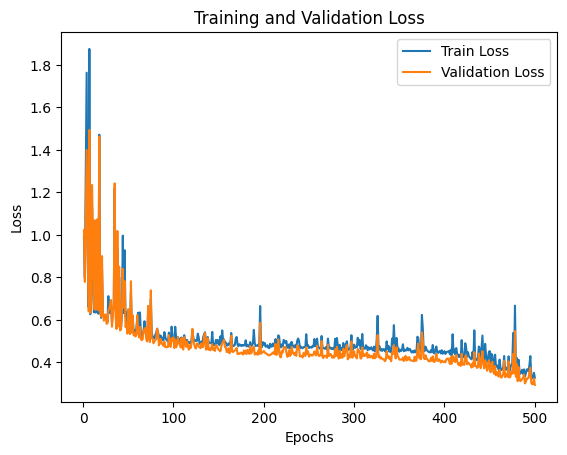

In [18]:
# Plotting training and validation losses
plt.plot(range(1, model.num_epochs + 1), model.train_losses, label='Train Loss')
plt.plot(range(1, model.num_epochs + 1), model.val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [19]:
# Predictions
y_pred_train = model.predict(X_train_tensor).numpy()
y_pred_test = model.predict(X_test_tensor).numpy()

In [20]:
# Metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [21]:
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.860445205479452
Test Accuracy: 0.8801369863013698


In [22]:
# Confusion matrix
print("Confusion Matrix for Train Data:")
print(confusion_matrix(y_train, y_pred_train))

Confusion Matrix for Train Data:
[[501  70]
 [ 93 504]]


In [23]:
print("Confusion Matrix for Test Data:")
print(confusion_matrix(y_test, y_pred_test))

Confusion Matrix for Test Data:
[[145  16]
 [ 19 112]]
